In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import t, norm
from joblib import Parallel, delayed

In [2]:
data = pd.read_csv('data.csv')

num_obvs = 100_000
r = np.array([.295, .49, .41, .415, .338, .64, .403, .476])

sector_indices = data['sector'].values
sec_loading = r[sector_indices]
datat = norm.ppf(data['p'])

In [23]:
def process_obs(obs):
    m_factor = obs[0]  
    sec_factor = obs[:len(r)][sector_indices]  
    res_factor = obs[len(r):]  

    control_variate = (
            r[0]**0.5 * m_factor
            + (sec_loading - r[0])**0.5 * sec_factor
            + (1 - sec_loading)**0.5 * res_factor
    )

    ind = control_variate < datat
    loss = np.zeros(len(data))

    if np.any(ind):
        loss[ind] = data.loc[ind, 'm'].values + data.loc[ind, 'd'].values * np.clip(t.rvs(df=3, size=sum(ind)), -5, 5)


    expected_control = np.mean(control_variate)
    alpha = np.cov(loss, control_variate)[0,1] / np.var(control_variate)
    loss -= alpha * (control_variate - expected_control)

    return np.sum(loss), np.var(loss)

In [ ]:
factors = np.random.normal(0, 1, (num_obvs, len(r) + len(data)))
antithetic_factors = -factors
combined_factors = np.vstack([factors, antithetic_factors])

answers = Parallel(n_jobs=-1, verbose=5)(delayed(process_obs)(obs) for obs in combined_factors)
answers = np.array(answers)

sample_losses = answers[:, 0]
sample_vars = answers[:, 1]

In [ ]:
VaR_antithetic = np.percentile(np.array(sample_losses), 0.1)

In [22]:
print("Avarage loss varianve:", np.mean(sample_vars))
print("Anthetic VaR at 99.9% Quantile:", VaR_antithetic)

Avarage loss varianve: 1356.9798208245
Anthetic VaR at 99.9% Quantile: -25.412814198061362


In [7]:
from scipy.stats import skew, kurtosis
print(f"Skewness: {skew(sample_losses):.5f}")
print(f"Kurtosis: {kurtosis(sample_losses):.5f}")

Skewness: -1.77950
Kurtosis: 21.19407


In [13]:
for q in [90, 95, 99, 99.5, 99.9]:
    print(f"{q}% Quantile: {np.percentile(sample_losses, q):.5f}")


90% Quantile: 1513.94833
95% Quantile: 2903.37669
99% Quantile: 7544.67455
99.5% Quantile: 10216.39926
99.9% Quantile: 17040.75408


In [11]:
var_99_9 = np.percentile(sample_losses, 99.9)
es_99_9 = np.mean(sample_losses[sample_losses >= var_99_9])
print(f"Expected Shortfall at 99.9%: {es_99_9:.5f}")

Expected Shortfall at 99.9%: 21473.03958


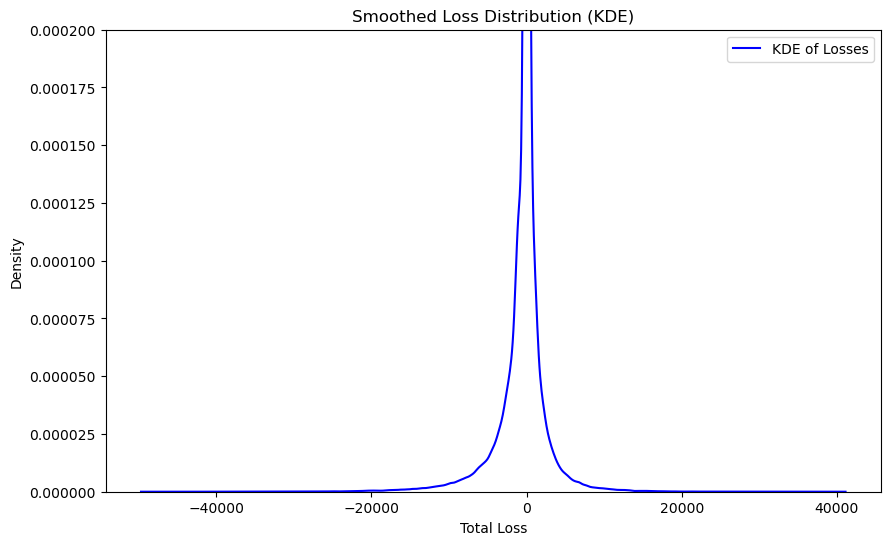

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

losses = np.array(sample_losses)

kde = gaussian_kde(losses)

x_values = np.linspace(min(losses), max(losses), 1000)
kde_values = kde(x_values)

plt.figure(figsize=(10, 6))
plt.plot(x_values, kde_values, color='blue', label='KDE of Losses')
plt.title("Smoothed Loss Distribution (KDE)")
plt.xlabel("Total Loss")
plt.ylim(0, 0.0002)
plt.ylabel("Density")
plt.legend()
plt.show()

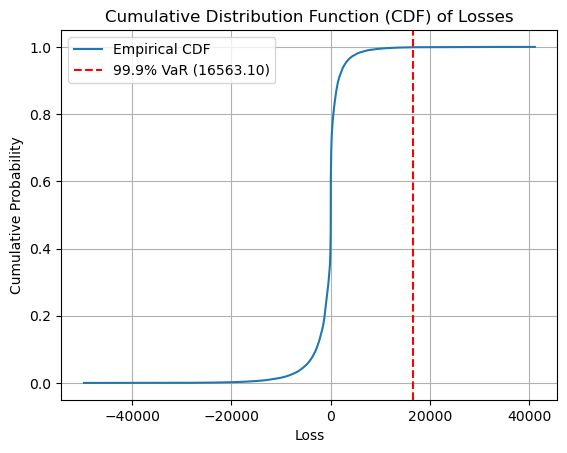

In [13]:
sorted_losses = np.sort(sample_losses)
cdf = np.arange(1, len(sorted_losses)+1) / len(sorted_losses)
plt.plot(sorted_losses, cdf, label="Empirical CDF")
plt.axvline(x=var_99_9, color='red', linestyle='--', label=f"99.9% VaR ({var_99_9:.2f})")
plt.title("Cumulative Distribution Function (CDF) of Losses")
plt.xlabel("Loss")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid()
plt.show()


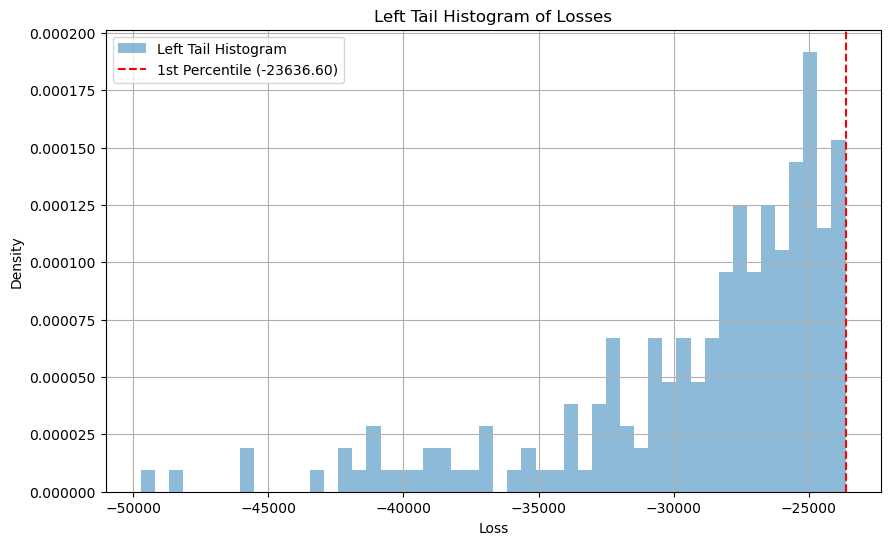

In [17]:
# Focus on the left tail (e.g., below the 10th percentile)
left_tail_threshold = np.percentile(sample_losses, 0.1)
tail_losses = sample_losses[sample_losses < left_tail_threshold]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(tail_losses, bins=50, density=True, alpha=0.5, label="Left Tail Histogram")
plt.title("Left Tail Histogram of Losses")
plt.xlabel("Loss")
plt.ylabel("Density")
plt.axvline(x=left_tail_threshold, color='red', linestyle='--', linewidth=1.5, label=f"1st Percentile ({left_tail_threshold:.2f})")
plt.legend()
plt.grid()
plt.show()


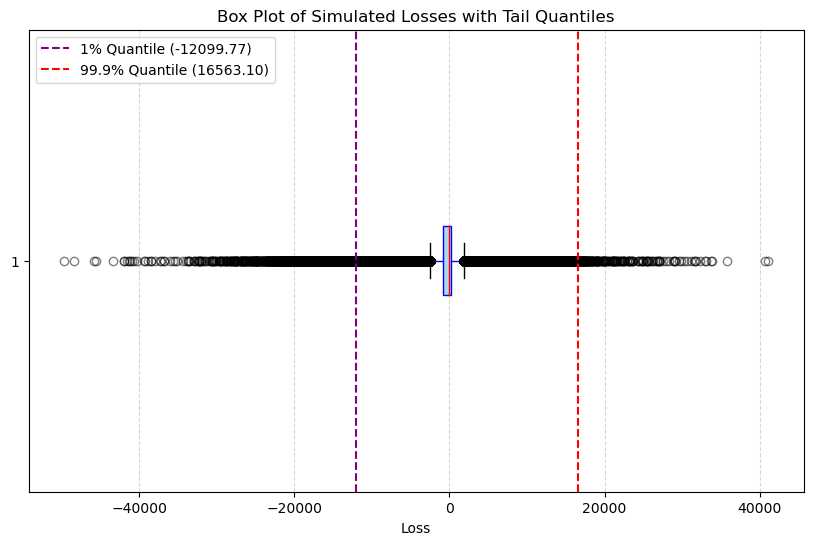

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a box plot for sample_losses
plt.figure(figsize=(10, 6))
plt.boxplot(sample_losses, vert=False, patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="blue"),
            whiskerprops=dict(color="blue"), medianprops=dict(color="red"),
            flierprops=dict(marker='o', color='orange', alpha=0.5))

# Highlight the extreme quantiles (e.g., 1st percentile and 99.9th percentile)
lower_threshold = np.percentile(sample_losses, 1)
upper_threshold = np.percentile(sample_losses, 99.9)

plt.axvline(lower_threshold, color='purple', linestyle='--', label=f"1% Quantile ({lower_threshold:.2f})")
plt.axvline(upper_threshold, color='red', linestyle='--', label=f"99.9% Quantile ({upper_threshold:.2f})")

# Add titles and labels
plt.title("Box Plot of Simulated Losses with Tail Quantiles")
plt.xlabel("Loss")
plt.legend()
plt.grid(axis='x', linestyle="--", alpha=0.5)

plt.show()


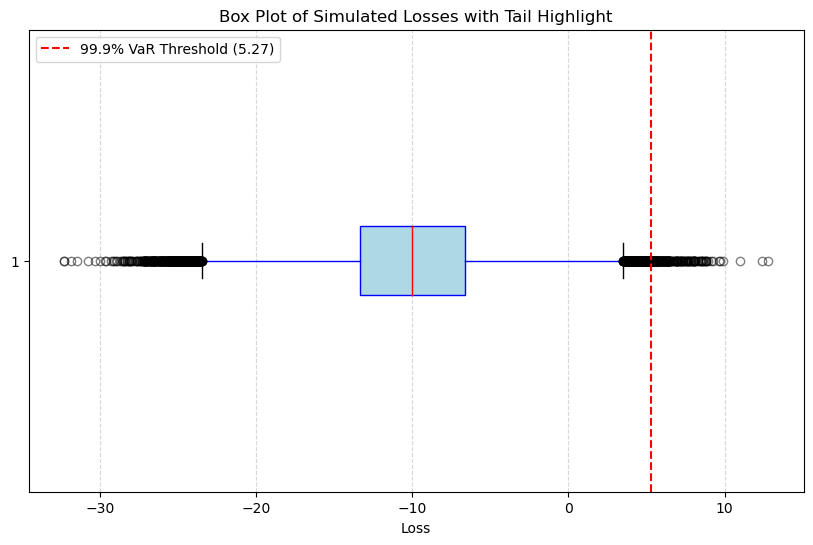

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic sample_losses as an example
np.random.seed(42)
sample_losses = np.random.normal(loc=-10, scale=5, size=200000)  # Simulated loss distribution
tail_threshold = np.percentile(sample_losses, 99.9)  # Tail threshold

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(sample_losses, vert=False, patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="blue"),
            whiskerprops=dict(color="blue"), medianprops=dict(color="red"),
            flierprops=dict(marker='o', color='orange', alpha=0.5))

# Highlight the 99.9% VaR Tail
plt.axvline(x=tail_threshold, color='red', linestyle='--', linewidth=1.5,
            label=f"99.9% VaR Threshold ({tail_threshold:.2f})")

# Add titles and labels
plt.title("Box Plot of Simulated Losses with Tail Highlight")
plt.xlabel("Loss")
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()


In [ ]:
import scipy.stats as stats
stats.probplot(sample_losses, dist="norm", plot=plt)
plt.plot([], [], 'o', label="Sample Quantiles")  # Dummy scatter point for legend
plt.plot([], [], 'r--', label="Theoretical Normal Quantiles")
plt.title("QQ Plot of Losses")
plt.grid()
plt.legend()
plt.show()